In [1]:
import numpy as np

In [2]:
np.random.seed(123)

In [7]:
data = np.random.normal(size=48) + 50

In [9]:
import seaborn as sns
import pymc3 as pm

1 #define _CUDA_NDARRAY_C
2 
3 #include <Python.h>
4 #include <structmember.h>
5 #include "theano_mod_helper.h"
6 
7 #include <numpy/arrayobject.h>
8 #include <iostream>
9 
10 #include "cuda_ndarray.cuh"
11 
12 #ifndef CNMEM_DLLEXPORT
13 #define CNMEM_DLLEXPORT
14 #endif
15 
16 #include "cnmem.h"
17 #include "cnmem.cpp"
18 
19 //If true, when there is a gpu malloc or free error, we print the size of allocated memory on the device.
20 #define COMPUTE_GPU_MEM_USED 0
21 
22 //If true, we fill with NAN allocated device memory.
23 #define ALLOC_MEMSET 0
24 
25 //If true, we print out when we free a device pointer, uninitialize a
26 //CudaNdarray, or allocate a device pointer
27 #define PRINT_FREE_MALLOC 0
28 
29 //If true, we do error checking at the start of functions, to make sure there
30 //is not a pre-existing error when the function is called.
31 //You probably need to set the environment variable
32 //CUDA_LAUNCH_BLOCKING=1, and/or modify the CNDA_THREAD_SYNC
33 //preprocessor macro 

216         //We init them to nan to make sure we catch more debug case.
217         cudaMemset(rval, 0xFF, size);
218         //printf("MEMSET\n");
219     }
220     #if PRINT_FREE_MALLOC
221         fprintf(stderr, "device malloc %p of size %d\n", rval, size);
222     #endif
223     return rval;
224 }
225 
226 int device_free(void *ptr)
227 {
228     #if PRECHECK_ERROR
229         cudaThreadSynchronize();
230         cudaError_t prevError = cudaGetLastError();
231         if (cudaSuccess != prevError)
232         {
233             fprintf(stderr,
234                     "Error existed before calling device_free. %s\n",
235                     cudaGetErrorString(prevError)
236                     );
237         }
238     #endif
239     #if PRINT_FREE_MALLOC
240         size_t free = 0, total = 0;
241         cudaError_t err2 = cudaMemGetInfo(&free, &total);
242         if (err2 != cudaSuccess){
243             cudaGetLastError();
244             fprintf(stderr,
245                    

426             rval = -1;
427         }
428         self->dev_structure = NULL;
429     }
430     if (self->host_structure)
431     {
432         free(self->host_structure);
433         self->host_structure = NULL;
434     }
435     self->nd = -1;
436     Py_XDECREF(self->base);
437     self->base = NULL;
438     return rval;
439 }
440 
441 
442 //make the rightmost coords change fastest
443 //TODO: why does a downward for-loop not work????
444 //TODO: use the log2_dims and driver code to remove / and %
445 //TODO: skip the last division (when d == 0)
446 #define decl_k_elemwise_unary_rowmajor(name, F) \
447 __global__ void name (unsigned int numEls,  \
448         unsigned int nd, \
449         const int * dim,  \
450         const float * a_data, const int * a_str, \
451         float * z_data, const int * z_str) \
452 { \
453     const unsigned int idx = blockIdx.x * blockDim.x + threadIdx.x; \
454     const unsigned int numThreads = blockDim.x * gridDim.x; \
455  \
456     for (un

651 // but this naming is very weird, makes it look like a macro
652 // we should figure out the correct convention and change to that
653 PyObject* CudaNdarray_ZEROS(int n, int * dims)
654 {
655 
656     size_t total_elements = 1;
657 
658     for(size_t i=0;i<n;i++){
659         // Detect overflow on unsigned integer
660         if (dims[i] != 0 && total_elements > (SIZE_MAX / dims[i])) {
661             PyErr_Format(PyExc_RuntimeError,
662                          "Can't store in size_t for the bytes requested %llu * %llu",
663                          (unsigned long long)total_elements,
664                          (unsigned long long)dims[i]);
665             return NULL;
666         }
667         total_elements*=dims[i];
668     }
669 
670     // total_elements now contains the size of the array, in reals
671     if (total_elements > (SIZE_MAX / sizeof(real))){
672         PyErr_Format(PyExc_RuntimeError,
673                      "Can't store in size_t for the bytes requested %ll

895 // TODO: make it return a view when the strides allow it even if it is not
896 //       c contiguous
897 PyObject * CudaNdarray_Reshape(CudaNdarray * self, PyObject * shape)
898 {
899     if(!CudaNdarray_is_c_contiguous(self))
900     {
901         // allocate new space
902         //TODO: test to see if we can re-use old one and take a new param to
903         //  use this
904         CudaNdarray* rval = (CudaNdarray*) CudaNdarray_Copy(self);
905         if (!rval)
906         {
907             return NULL;
908         }
909 
910         CudaNdarray* ret = (CudaNdarray*) CudaNdarray_Reshape(rval, shape);
911         Py_XDECREF(rval);
912         return (PyObject*)ret;
913     }
914 
915     // check shape tuple
916     unsigned int rval_nd;
917     unsigned int * rval_dims;
918     size_t rval_size = 1;
919 
920     if (PyTuple_Check(shape)){
921         // copy shape to integer array
922         rval_nd = PyTuple_Size(shape);
923     }else if (PyInt_Check(shape)){
924         rva

1096         } else {
1097             // Keep the refcount consistent
1098             Py_INCREF(indices_obj);
1099         }
1100         PyArray_Descr* float32_descr = PyArray_DescrFromType(NPY_FLOAT32);
1101         PyObject * indices_float32 = NULL;
1102         indices_float32 = PyArray_View((PyArrayObject*)indices_obj,
1103                                                   float32_descr, NULL);
1104         if (verbose) printf("ndarray indices\n");
1105         if (!indices_float32) {
1106             Py_DECREF(indices_obj);
1107             return NULL;
1108         }
1109 
1110         indices = (CudaNdarray*) CudaNdarray_New();
1111         if (verbose) printf("\nndarray after new\n");
1112         if (! indices){
1113             Py_DECREF(indices_obj);
1114             Py_DECREF(indices_float32);
1115             return NULL;
1116         }
1117         if (CudaNdarray_CopyFromArray(indices,
1118                                       (PyArrayObject *)indices_float32)){
1119

1292             {
1293                 int ty = std::min(CudaNdarray_HOST_DIMS(out)[2], max_threads);
1294                 int tx = std::min(CudaNdarray_HOST_DIMS(out)[1], max_threads / ty);
1295                 dim3 n_threads(tx, ty, 1);
1296                 if (verbose)
1297                     printf("cudaGetLastError=%d, nd=%d"
1298                            " kernel config: (n_blocks.x=%d, n_blocks.y=%d,"
1299                            " n_threads.x=%i, n_threads.y=%i)\n",
1300                            cudaGetLastError(), self->nd,
1301                            n_blocks.x, n_blocks.y, n_threads.x, n_threads.y);
1302                 k3<<<n_blocks, n_threads>>>(
1303                         dims[0], //dimensions
1304                         dims[1],
1305                         dims[2],
1306                         (npy_int64*) CudaNdarray_DEV_DATA(indices),
1307                         CudaNdarray_DEV_DATA(out),
1308                         CudaNdarray_HOST_STRIDES(out)[0], 

1492     CudaNdarray * other = (CudaNdarray *)py_other;
1493     if(!CudaNdarray_is_c_contiguous(self) || !CudaNdarray_is_c_contiguous(other)){
1494         PyErr_SetString(PyExc_TypeError, "We have implementet only the c_contiguous version for now.");
1495         return NULL;
1496     }
1497 
1498     //standard elemwise size checks
1499     if (self->nd != other->nd)
1500     {
1501         PyErr_SetString(PyExc_TypeError, "CudaNdarray_add: need same number of dims");
1502         return NULL;
1503     }
1504     //standard elemwise dim checks
1505     unsigned int size = 1;
1506     for (int i = 0; i< self->nd; ++i)
1507     {
1508         if (CudaNdarray_HOST_DIMS(self)[i] != CudaNdarray_HOST_DIMS(other)[i])
1509         {
1510             PyErr_SetString(PyExc_TypeError, "need same dimensions");
1511             return NULL;
1512         }
1513         size *= (unsigned int) CudaNdarray_HOST_DIMS(self)[i];
1514     }
1515     CudaNdarray * rval = (CudaNdarray *)CudaNdarray_New();

1671         case IADD:
1672             k3 = k_ielem_3<IADD>;
1673             k4 = k_ielem_4<IADD>;
1674             k6 = k_ielem_6<IADD>;
1675             break;
1676         case IDIV:
1677             k3 = k_ielem_3<IDIV>;
1678             k4 = k_ielem_4<IDIV>;
1679             k6 = k_ielem_6<IDIV>;
1680             break;
1681         case CPY:
1682             k3 = k_ielem_3<CPY>;
1683             k4 = k_ielem_4<CPY>;
1684             k6 = k_ielem_6<CPY>;
1685             break;
1686         default:
1687             assert (0);
1688             PyErr_Format(
1689                 PyExc_TypeError,
1690                 "CudaNdarray_inplace_elemwise invalid fct_nb (%i).",
1691                 (int)fct_nb);
1692             return -1;
1693     }
1694     if (!CudaNdarray_Check(py_self)) {
1695         PyErr_SetString(
1696             PyExc_TypeError,
1697             "CudaNdarray_inplace_elemwise need a CudaNdarray on left");
1698         return -1;
1699     }
1700     CudaNdarray 

1879                 CNDA_THREAD_SYNC;
1880                 cudaError_t err = cudaGetLastError();
1881                 if (cudaSuccess != err)
1882                 {
1883                     PyErr_Format(
1884                         PyExc_RuntimeError,
1885                         "CudaNdarray_inplace_elemwise case2: Cuda error: %s: %s.\n",
1886                         "k3",
1887                         cudaGetErrorString(err));
1888                     Py_XDECREF(new_other);
1889                     return -1;
1890                 }
1891             }
1892             break;
1893         case 3:
1894             {
1895                 //TODO:  Dimshuffle so that at least one of the arrays
1896                 //       has a contiguous dimension on the thread idx.
1897                 dim3 n_blocks(
1898                         std::min(
1899                             CudaNdarray_HOST_DIMS(self)[0],
1900                             NUM_VECTOR_OP_BLOCKS),
1901                        

2041                 //    n_blocks.z /= 2;
2042                 n_blocks.z = 1;
2043                 dim3 n_threads(
2044                         std::min(
2045                             CudaNdarray_HOST_DIMS(self)[3],
2046                             NUM_VECTOR_OP_THREADS_PER_BLOCK)
2047                     //TODO: DON'T YOU NEED TO PUT DIMS[4] in here???
2048                     //TODO: DON'T YOU NEED TO PUT DIMS[5] in here???
2049                             );
2050                 k6<<<n_blocks, n_threads>>>(
2051                         CudaNdarray_HOST_DIMS(self)[0],
2052                         CudaNdarray_HOST_DIMS(self)[1],
2053                         CudaNdarray_HOST_DIMS(self)[2],
2054                         CudaNdarray_HOST_DIMS(self)[3],
2055                         CudaNdarray_HOST_DIMS(self)[4],
2056                         CudaNdarray_HOST_DIMS(self)[5],
2057                         CudaNdarray_DEV_DATA(self),
2058                         CudaNdarray_HOST_STRIDES(s

2231 /////////////////////
2232 // Mapping protocol
2233 /////////////////////
2234 
2235 // Will by called by __len__ in Python
2236 static Py_ssize_t
2237 CudaNdarray_len(PyObject * py_self)
2238 {
2239     CudaNdarray * self = (CudaNdarray*) py_self;
2240     if (self->nd <= 0)
2241     {
2242         return (Py_ssize_t) 0;
2243     }
2244     else
2245     {
2246         return (Py_ssize_t) CudaNdarray_HOST_DIMS(self)[0];
2247     }
2248 }
2249 
2250 // Will by called by __getitem__ in Python
2251 PyObject *
2252 CudaNdarray_Subscript(PyObject * py_self, PyObject * key)
2253 {
2254     int verbose = 0;
2255     if (verbose) fprintf(stderr, "Subscript .... \n");
2256     CudaNdarray * self = (CudaNdarray*) py_self;
2257     PyObject * py_rval = NULL;
2258     CudaNdarray * rval = NULL;
2259     PyObject * intobj = NULL;
2260 
2261     //PyObject_Print(key, stderr, 0);
2262 
2263     if (key == Py_Ellipsis)
2264     {
2265         Py_INCREF(py_self);
2266         return py_self;
2267

2441                     {
2442                         std::cerr << "start " << start << "\n";
2443                         std::cerr << "stop " << stop << "\n";
2444                         std::cerr << "step " << step << "\n";
2445                         std::cerr << "slen " << slen << "\n";
2446                     }
2447                     ++rval_d;
2448                 }
2449                 else if ((intobj=PyNumber_Int(key_d)))
2450                 {
2451                     assert(PyArray_IsAnyScalar(key_d));
2452                     int d_idx = PyInt_AsLong(intobj);
2453                     Py_DECREF(intobj);
2454                     intobj = NULL;
2455                     int d_dim = CudaNdarray_HOST_DIMS(self)[d];
2456 
2457                     if ((d_idx >= 0) && (d_idx < d_dim))
2458                     {
2459                         //normal indexing
2460                         rval->devdata += d_idx * CudaNdarray_HOST_STRIDES(self)[d];
2461                     }
2462

2635         if (verbose)
2636             fprintf(stderr, "CudaNdarray_setitem error end\n");
2637         return -1;
2638     }
2639 
2640     assert (rval->base == baseSavedForComparison);
2641     assert (rval->dev_structure_fresh);
2642 
2643     // Clean up locally-created references
2644     Py_DECREF(rval);
2645     Py_XDECREF(new_value);
2646 
2647     return 0;
2648 }
2649 
2650 
2651 PyMappingMethods CudaNdarrayMappingMethods = {
2652     CudaNdarray_len, //lenfunc mp_length;               __len__
2653     CudaNdarray_Subscript, //binaryfunc mp_subscript;   __getitem__
2654     CudaNdarray_setitem //objobjargproc mp_ass_subscript;                __setitem__
2655 };
2656 
2657 ////////////////////
2658 //
2659 ////////////////////
2660 
2661 static PyObject *
2662 CudaNdarray_get_shape(CudaNdarray *self, void *closure)
2663 {
2664     if (self->nd < 0)
2665     {
2666         PyErr_SetString(PyExc_ValueError, "CudaNdarray not initialized");
2667         return NULL;
2668     

2866   put_in_dict(dict, "maxThreadsDim2", deviceProp.maxThreadsDim[2]);
2867   put_in_dict(dict, "maxGridSize0", deviceProp.maxGridSize[0]);
2868   put_in_dict(dict, "maxGridSize1", deviceProp.maxGridSize[1]);
2869   put_in_dict(dict, "maxGridSize2", deviceProp.maxGridSize[2]);
2870   put_in_dict(dict, "memPitch", deviceProp.memPitch);
2871   put_in_dict(dict, "textureAlignment", deviceProp.textureAlignment);
2872   put_in_dict(dict, "clockRate", deviceProp.clockRate);
2873 #if CUDART_VERSION >= 2000
2874   put_in_dict(dict, "deviceOverlap", deviceProp.deviceOverlap);
2875 #endif
2876 #if CUDART_VERSION >= 2020
2877   put_in_dict(dict, "kernelExecTimeoutEnabled", deviceProp.kernelExecTimeoutEnabled);
2878   put_in_dict(dict, "integrated", deviceProp.integrated);
2879   put_in_dict(dict, "canMapHostMemory", deviceProp.canMapHostMemory);
2880   put_in_dict(dict, "computeMode", deviceProp.computeMode);
2881   //in the doc of this fct tell that 0 - Normal mode, 1 - only 1 context, 2 - no 

3091     0,                         /*tp_setattr*/
3092     0,                         /*tp_compare*/
3093     CudaNdarray_repr,          /*tp_repr*/
3094     &CudaNdarrayNumberMethods, /*tp_as_number*/
3095     0,                         /*tp_as_sequence*/
3096     &CudaNdarrayMappingMethods,/*tp_as_mapping*/
3097     0,                         /*tp_hash */
3098     0,                         /*tp_call*/
3099     0,                         /*tp_str*/
3100     0,                         /*tp_getattro*/
3101     0,                         /*tp_setattro*/
3102     0,                         /*tp_as_buffer*/
3103 #if PY_MAJOR_VERSION >= 3
3104     // Py_TPFLAGS_CHECKTYPES is always true and was removed in Python 3.
3105     Py_TPFLAGS_DEFAULT | Py_TPFLAGS_BASETYPE, /*tp_flags*/
3106 #else
3107     Py_TPFLAGS_DEFAULT | Py_TPFLAGS_BASETYPE | Py_TPFLAGS_CHECKTYPES, /*tp_flags*/
3108 #endif
3109     "CudaNdarray objects",     /* tp_doc */
3110     0,                         /* tp_traverse */


3285 CudaNdarray_active_device_name(PyObject* _unused, PyObject* _unused_args) {
3286     // NB: No cuda error checking here; keeps things simple, and it's not
3287     // really necessary.
3288     int currentDevice;
3289     cudaGetDevice(&currentDevice);
3290 
3291     cudaDeviceProp deviceProp;
3292     cudaGetDeviceProperties(&deviceProp, currentDevice);
3293     return PyString_FromString(deviceProp.name);3428     if (((CudaNdarray*)l)->nd != 2)
3429     {
3430         PyErr_SetString(PyExc_TypeError, "need 2d CudaNdarray arg for now");
3431         goto CudaNdarray_dot_fail;
3432     }
3433     if (((CudaNdarray*)r)->nd != 2)
3434     {
3435         PyErr_SetString(PyExc_TypeError, "need 2d CudaNdarray arg for now");
3436         goto CudaNdarray_dot_fail;
3437     }
3438     rval = CudaNdarray_New();
3439     if (!rval)
3440     {
3441         goto CudaNdarray_dot_fail;
3442     }
3443     int dims[2];
3444     dims[0] = CudaNdarray_HOST_DIMS((CudaNdarray*)l)[0];
3445     dims[

3590     {"synchronize", CudaNdarray_synchronize, METH_NOARGS, "Used to synchronize the device"},
3591     {"cublas_v2", CudaNdarray_cublasv2, METH_NOARGS,
3592      "Used to know if this version of cuda_ndarray is linked with cublas v2."},
3593     {NULL, NULL, NULL, NULL}  /* Sentinel */
3594 };
3595 
3596 #define CNDA_MOD_NAME "cuda_ndarray"
3597 #define CNDA_DOCSTRING "CUDA implementation of a numpy ndarray-like object."
3598 
3599 #if PY_MAJOR_VERSION == 3
3600 static struct PyModuleDef cuda_ndarray_moduledef =
3601 {
3602     PyModuleDef_HEAD_INIT,
3603     CNDA_MOD_NAME,
3604     CNDA_DOCSTRING,
3605     -1,     /* size of per-interpreter state of the module,
3606                or -1 if the module keeps state in global variables. */
3607     module_methods
3608 };
3609 
3610 PyMODINIT_FUNC
3611 PyInit_cuda_ndarray(void)
3612 #else
3613 PyMODINIT_FUNC
3614 initcuda_ndarray(void)
3615 #endif
3616 {
3617     import_array();
3618 
3619     PyObject* m;
3620 
3621     if (PyType_Rea

3988         case 1: // vector
3989             {
3990                 if (verbose) fprintf(stderr, "Copying non-contiguous vector\n");
3991                 if (verbose) fprint_CudaNdarray(stderr, other);
3992                 unsigned int n_blocks = std::min(size,
3993                                                  (unsigned int)NUM_VECTOR_OP_BLOCKS);
3994                 unsigned int n_threads = std::min(ceil_intdiv(size, n_blocks),
3995                                                   (unsigned int)NUM_VECTOR_OP_THREADS_PER_BLOCK);
3996                 k_copy_1d<<<n_blocks, n_threads>>>(size,
3997                                             CudaNdarray_DEV_DATA(other),
3998                                             CudaNdarray_HOST_STRIDES(other)[0],
3999                                             CudaNdarray_DEV_DATA(self),
4000                                             CudaNdarray_HOST_STRIDES(self)[0]);
4001                 CNDA_THREAD_SYNC;
4002                 cudaError_

4289         case 0x110: CHK_STRIDE_SGEMM(T, T, CudaNdarray_HOST_DIMS(C)[1], CudaNdarray_HOST_DIMS(C)[0], CudaNdarray_HOST_DIMS(A)[1], alpha, b, sb_1, a, sa_1, beta, c, sc_0); break;
4290         case 0x001: CHK_STRIDE_SGEMM(T, T, CudaNdarray_HOST_DIMS(C)[0], CudaNdarray_HOST_DIMS(C)[1], CudaNdarray_HOST_DIMS(A)[1], alpha, a, sa_0, b, sb_0, beta, c, sc_1); break;
4291         case 0x101: CHK_STRIDE_SGEMM(N, T, CudaNdarray_HOST_DIMS(C)[0], CudaNdarray_HOST_DIMS(C)[1], CudaNdarray_HOST_DIMS(A)[1], alpha, a, sa_1, b, sb_0, beta, c, sc_1); break;
4292         case 0x011: CHK_STRIDE_SGEMM(T, N, CudaNdarray_HOST_DIMS(C)[0], CudaNdarray_HOST_DIMS(C)[1], CudaNdarray_HOST_DIMS(A)[1], alpha, a, sa_0, b, sb_1, beta, c, sc_1); break;
4293         case 0x111: CHK_STRIDE_SGEMM(N, N, CudaNdarray_HOST_DIMS(C)[0], CudaNdarray_HOST_DIMS(C)[1], CudaNdarray_HOST_DIMS(A)[1], alpha, a, sa_1, b, sb_1, beta, c, sc_1); break;
4294         default: PyErr_Format(PyExc_ValueError, "some matrix has no unit stride 

4452                          CudaNdarray_HOST_STRIDES(B)[0],
4453                          CudaNdarray_HOST_STRIDES(C)[0],
4454                          CudaNdarray_HOST_DIMS(A)[0],
4455                          CudaNdarray_HOST_DIMS(A)[1],
4456                          CudaNdarray_HOST_DIMS(B)[0],
4457                          CudaNdarray_HOST_DIMS(C)[0]);
4458             Py_XDECREF(A_new);
4459             Py_XDECREF(B_new);
4460             return -1;
4461         }
4462     }
4463 
4464     CNDA_THREAD_SYNC;
4465     Py_XDECREF(A_new);
4466     Py_XDECREF(B_new);
4467 
4468     if (CUBLAS_STATUS_SUCCESS != err)
4469     {
4470         if (!used_dot)
4471         {
4472             PyErr_Format(PyExc_RuntimeError,
4473                          "cublasSgemv failed (%i)",
4474                          err);
4475         } else {
4476         PyErr_Format(PyExc_RuntimeError,
4477                      "cublasSdot failed (%i)",
4478                      err);
4479         }
4480       

4796                 Z[blockIdx.x*sZ0] = buf[0];
4797             }
4798         }
4799     }
4800 }
4801 /**
4802  * Dimensions in which the self has size 1 and A has size > 1 are considered summing dimensions
4803  * Dimensions in which self has size > 1 and A has size > 1 are considered non-summing dimensions, and in this case their sizes must be equal.
4804  */
4805 int
4806 CudaNdarray_reduce_sum(CudaNdarray * self, CudaNdarray * A)
4807 {
4808     int verbose = 0;
4809     //check input rank
4810     if (self->nd != A->nd)
4811     {
4812         PyErr_Format(PyExc_TypeError, "Rank mismatch in CudaNdarray_sum: %i vs %i", self->nd, A->nd);
4813         return -1;
4814     }
4815     for (int i = 0; i < self->nd; ++i)
4816     {
4817         if ((CudaNdarray_HOST_DIMS(self)[i] > 1) && (CudaNdarray_HOST_DIMS(self)[i] != CudaNdarray_HOST_DIMS(A)[i]))
4818         {
4819             PyErr_Format(PyExc_TypeError, "Dimension mismatch in CudaNdarray_sum: self->dim[%i] == %i , A->dim[%i] 

5165     if (!ignoreBase && cnda1->base != cnda2->base)
5166     {
5167         if(verbose) fprintf(stdout, "CUDANDARRAY_EQUAL FAILED : 4");
5168         return 0;
5169     }
5170     else if (cnda1->data_allocated != cnda2->data_allocated)
5171     {
5172         if(verbose) fprintf(stdout, "CUDANDARRAY_EQUAL FAILED : 5");
5173         return 0;
5174     }
5175     else if (cnda1->data_allocated && cnda1->devdata != cnda2->devdata)
5176     {
5177         if(verbose) fprintf(stdout, "CUDANDARRAY_EQUAL FAILED : 6");
5178         // no need to check devdata if data is not allocated
5179         return 0;
5180     }
5181 
5182     return 1;
5183 }
5184 
5185 
5186 int
5187 CudaNdarray_Equal(CudaNdarray *cnda1, CudaNdarray *cnda2)
5188 {
5189     return CudaNdarray_EqualAndIgnore(cnda1, cnda2, 0, 0);
5190 }
5191 
5192 int
5193 cnda_copy_structure_to_device(const CudaNdarray * self)
5194 {
5195     //If the device structure do not exists, create it.
5196     //We allocate it here as we do 

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

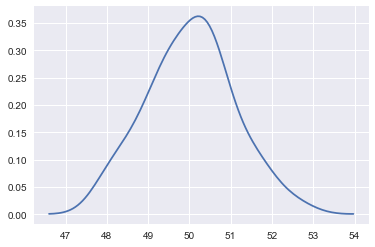

In [8]:
sns.kdeplot(data)

In [10]:
with pm.Model() as model_g:
    mu = pm.Uniform('mu', 40, 75)
    sigma = pm.HalfNormal('sigma', sd=10)
    y = pm.Normal('y', mu=mu, sd=sigma, observed=data)
    
    trace_g = pm.sample(1100)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -78.291: 100%|███████████████████████████████████████████████| 200000/200000 [00:11<00:00, 17870.87it/s]
Finished [100%]: Average ELBO = -78.286
100%|█████████████████████████████████████████████████████████████████████████████| 1100/1100 [00:01<00:00, 749.16it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001377BD181D0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001377B8CE358>]], dtype=object)

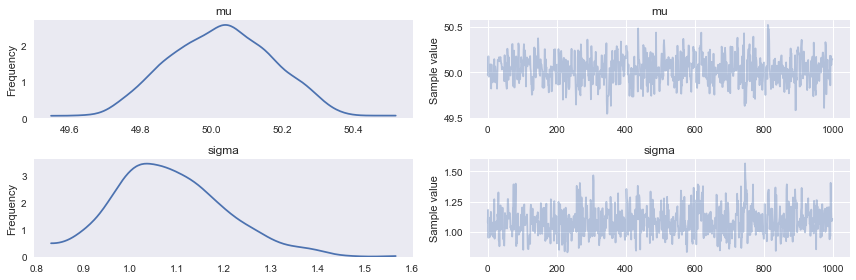

In [11]:
chain_g = trace_g[100:]
pm.traceplot(chain_g)

In [12]:
pm.df_summary(chain_g)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
mu,50.028598,0.151815,0.006582,49.738634,50.297637
sigma,1.085500,0.115916,0.004910,0.852676,1.305064


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 154.71it/s]
C:\Anaconda3\lib\site-packages\matplotlib\cbook.py:2649: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


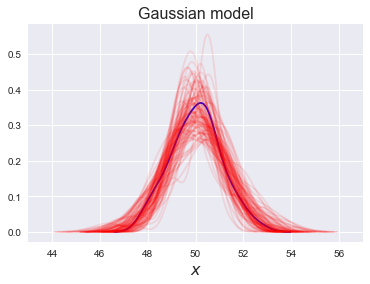

In [16]:
y_pred = pm.sample_ppc(chain_g, 100, model_g, size=len(data))
sns.kdeplot(data, c='b')
for i in y_pred['y']:
    sns.kdeplot(i, c='r', alpha=0.1)

plt.xlim(43, 57)
plt.title('Gaussian model', fontsize=16)
plt.xlabel('$x$', fontsize=16)

In [17]:
from scipy import stats

In [18]:
np.mean(stats.t(loc=0, scale=1, df=1).rvs(100))

0.05703585690353874